## ITM430 - Term Project
___

In [1]:
import numpy as np
import pandas as pd
import math

### Defining Functions
'Reducing Answers' remaps infrequent answers to null values below `reduce_level`.
___

In [2]:
def reducing_answers(df, col, reduce_level=0.05):
    
    data = df[col].copy()
    
    infrequent_answers = data.value_counts(normalize=True, dropna=False) < reduce_level
    
    infrequent_mask = data.map(infrequent_answers)
    data.loc[infrequent_mask] = pd.NA
    
    return data

### Loading Data
*Nonresident* dataset from BSU Admissions 2023
___

In [78]:
nonresident = pd.read_excel('nonresident version 2.xlsx')
nonresident.columns

Index(['Unique ID', 'Admit Term', 'Admit Type', 'Application Period',
       'Application Month', 'Submitted Date', 'App Type', 'Application Fee',
       'App Decision Date', 'Time from App to Decision',
       'Opened Decision Email', 'Residency', 'Residency State', 'City',
       'State', 'County', 'Recruitment Region', 'HS GPA', 'HS GPA Range',
       'HS Accredited', 'Major', 'College', 'Department', 'Intent to Enroll',
       'Intent to Enroll Submitted Month/Year',
       'Intent to Enroll Submitted Date', 'Scholarship Awarded', 'Scholarship',
       '# of Days from decision to scholarship award', 'Pell Grant',
       'FAFSA on File flag', 'Orientation Registration Date',
       'Orientation Attended', 'Honors Status', 'Housing', 'Housing.1',
       'Housing Hall', 'Housing Submitted', 'First Generation',
       'Parent Education Level', 'ID Rural/Urban', 'Race', 'Hispanic',
       'Enrollment Date', 'Campus Tour', 'Attended Discover',
       'Received Viewbook', 'Attended Virtua

### Bulk removal of irrelevant, redundant variables
___

In [4]:
nonresident.drop(columns=['Unique ID', # Not generalizable
                          'Admit Term', # Subset too small
                          'Application Period', # Substitute 'Submitted Date' and 'App Decision Date'
                          'Application Month', # Substitute as above
                          'App Type', # Single value
                          'Time from App to Decision', # Substitute 'Submitted Date' 
                          'Opened Decision Email', # Irrelevant, not actionable
                          'Residency', # Single value
                          'Residency State', # Substitute away_from_home
                          'County', # Substitue 'away_from_home'
                          'Recruitment Region', # Substitute 'away_from_home'
                          'HS GPA Range', # Substitute 'HS GPA'
                          'HS Accredited', # Subset too small
                          'Major', # Too granular for categorical data
                          'Department', # Too granular for categorical data
                          'Intent to Enroll', # Irrelevant, not actionalbe
                          'Intent to Enroll Submitted Month/Year', # Substitute 'Intent to Enroll Submitted Date' with a transformation
                          'Scholarship', # Relevancy
                          '# of Days from decision to scholarship award', # Relevancy
                          'Orientation Registration Date', # Irrelevant, not actionable
                          'Orientation Attended', # Too many for dummies, ?
                          'Housing.1', # Subset too small
                          'Housing Hall', # Too granular
                          'Housing Submitted', # Irrelevant, not actionable
                          'ID Rural/Urban', # Single value
                          'Attended Discover', # Single value
                          'Received Viewbook', # Single value
                          'Concurrent Enrollment', # Substitute 'concurrent_gpa_x_cred'
                          'Currently Enrolled', # Soft proxy for target variable
                          'CUM for GPACredits Earned', # Irrelevant
                          'Total BSU Degree Seeking GPA', # Substitute 'Fall 2021 GPA'
                          'Boise State GPA range', # Substitute 'Fall 2021 GPA'
                          'Currently Enrolled.1'], # Duplicate
                 inplace=True)

### Date Variable Transformations
`Submitted Date`, `App Decision Date`, `Intent to Enroll Submitted Date`, and `Enrollment Date` are transformed then dropped.
___

In [5]:
# Transforming '[Application] Submitted Date' and 'App[lication] Decision Date' to single value.
# Additionally transforming 'Days to Intent to Enroll'
nonresident['Submitted Date'] = pd.to_datetime(nonresident['Submitted Date'])
nonresident['App Decision Date'] = pd.to_datetime(nonresident['App Decision Date'])
nonresident['Intent to Enroll Submitted Date'] = pd.to_datetime(nonresident['Intent to Enroll Submitted Date'])
nonresident['Enrollment Date'] = pd.to_datetime(nonresident['Enrollment Date'])

# Days between application submission and acceptance
nonresident['days_to_decision'] = nonresident['App Decision Date'] - nonresident['Submitted Date']
nonresident['days_to_decision'] = nonresident['days_to_decision'].dt.days

# Days between acceptance and intent
nonresident['days_to_ite'] = nonresident['Intent to Enroll Submitted Date'] - nonresident['App Decision Date']
nonresident['days_to_ite'] = nonresident['days_to_ite'].dt.days

# Days between intent and enrollment
nonresident['days_to_enroll'] = nonresident['Enrollment Date'] - nonresident['Intent to Enroll Submitted Date']
nonresident['days_to_enroll'] = nonresident['days_to_enroll'].dt.days

# Relative days 'early' (expressed as more negative) within application submission date
nonresident['days_app_submitted_early'] = nonresident['Submitted Date'] - nonresident['Submitted Date'].max()
nonresident['days_app_submitted_early'] = nonresident['days_app_submitted_early'].dt.days

# Dropping now transformed columns
nonresident.drop(columns=['Submitted Date', 'App Decision Date', 'Intent to Enroll Submitted Date', 'Enrollment Date'], inplace=True)

# Removing negative values
nonresident.loc[nonresident['days_to_ite'] < 0, 'days_to_ite'] = -1

### Renaming Instances
___

In [6]:
# Renaming values for easier reading when transformed to dummies
nonresident['Admit Type'].replace({'New- HS in progress' : 'new', 
                                   'New- HS in progress with college credit' : 'new_college_credit', 
                                   'Returning- Was NEW never enroll' : 'returning'}, 
                                  inplace=True)

In [7]:
nonresident['Application Fee'].fillna('Received', inplace=True)
nonresident['Application Fee'].replace({'Waived' : 1, 'Received' : 0}, inplace=True)
nonresident.rename(columns={'Application Fee' : 'Application Fee Waived'}, inplace=True)

In [8]:
nonresident['College'] = reducing_answers(nonresident, 'College', reduce_level=0.1)
nonresident['College'].fillna('BSU', inplace=True)

In [9]:
nonresident['Scholarship Awarded'].replace({'Yes' : 1, 'No' : 0}, inplace=True)

In [10]:
nonresident['Pell Grant'].replace({'Yes' : 1, 'No' : 0}, inplace=True)

In [11]:
nonresident['FAFSA on File flag'].replace({'Yes' : 1, 'No' : 0}, inplace=True)

In [12]:
nonresident['Honors Status'].fillna('zero', inplace=True)

mask = nonresident['Honors Status'].str.contains('Honors')
nonresident.loc[mask, 'Honors Status'] = 'one'
nonresident['Honors Status'].replace({'one' : 1, 'zero' : 0}, inplace=True)

nonresident.rename(columns={'Honors Status' : 'Honors Possible'}, inplace=True)

In [13]:
nonresident['Housing'].replace({'On Campus' : 1, 'Off Campus' : 0}, inplace=True)
nonresident.rename(columns={'Housing' : 'Housing On Campus'}, inplace=True)

In [14]:
nonresident['First Generation'].replace({'Yes' : 1, 'No' : 0}, inplace=True)

In [15]:
nonresident['Parent Education Level'].value_counts(normalize=True, dropna=False)

Bachelor Degree                               0.444514
Master or Doctorate or Professional Degree    0.309091
Some College but No Degree                    0.102821
Associate Degree                              0.067712
High School Diploma or Equivalent             0.061442
Some School but No High School Diploma        0.010031
Unknown                                       0.004389
Name: Parent Education Level, dtype: float64

In [16]:
nonresident['Parent Education Level'] = reducing_answers(nonresident, 'Parent Education Level', reduce_level=0.15)
nonresident['Parent Education Level'].fillna('Less Than Bachelors', inplace=True)

nonresident.drop(columns='First Generation', inplace=True)

In [17]:
nonresident['Hispanic'].replace({'Yes' : 1, 'No' : 0}, inplace=True)

In [18]:
nonresident['Campus Tour'].replace({'Yes' : 1, 'No' : 0}, inplace=True)

In [19]:
nonresident['Attended Virtual Event'].replace({'Yes' : 1, 'No' : 0}, inplace=True)

In [20]:
nonresident['Legal Sex'].replace({'Female' : 1, 'Male' : 0}, inplace=True)
nonresident.rename(columns={'Legal Sex' : 'Female'}, inplace=True)

In [21]:
nonresident['concurrent_gpa_x_credits'] = nonresident.apply((lambda x: x['Concurrent Enrollment GPA'] * x['Concurrent Enrollment Credits']), axis=1)
nonresident['concurrent_gpa_x_credits'].fillna(0, inplace=True)
nonresident['ln_concurrent_gpa_x_credits'] = nonresident['concurrent_gpa_x_credits'].apply(lambda x: math.log(x + 1))

nonresident.drop(columns=['Concurrent Enrollment GPA', 
                          'Concurrent Enrollment Credits', 
                          'concurrent_gpa_x_credits'], 
                inplace=True)

In [22]:
nonresident['fa21_failed_cred'] = nonresident.apply((lambda x: x['Fall 2021 Attempted Credits'] - x['Fall 2021 Credits']), axis=1)

nonresident.drop(columns='Fall 2021 Attempted Credits', inplace=True)

In [23]:
nonresident['hs_fa21_gpa_delta'] = nonresident['Fall 2021 GPA'] - nonresident['HS GPA']
nonresident['hs_fa21_gpa_delta'].fillna(0, inplace=True)

In [24]:
nonresident['Retained from 1st to 2nd year'].replace({'Yes' : 1, 'No' : 0}, inplace=True)
nonresident['Retained from Fall to Spring?'].replace({'Yes' : 1, 'No' : 0}, inplace=True)

### Distance Transformation
Transforming `City` and `State` to a longitude and latitude then calculating a geodesic distance in miles to Boise, ID.  

Creates variables `away_from_home` and the natural log transformation: `ln_away_from_home`.
___

In [25]:
# Address for distance from home
nonresident['Address'] = nonresident['City'] + ', ' + nonresident['State']

In [26]:
from geopy.geocoders import Nominatim

def get_latlong(address):
    """Return longitude and latitude at address"""
    
    geolocator = Nominatim(user_agent='blincolm')
    
    try:
        location = geolocator.geocode(address, timeout=None)
        latitude = location.latitude
        longitude = location.longitude
        result = latitude, longitude
        
    except AttributeError:
        result = np.nan
    
    return result

In [27]:
from geopy.distance import geodesic

boise_latlong = get_latlong('Boise, ID')

def distance_from_boise(address):
    """Returns distance in miles from City, ST"""
    
    try:
        address_latlong = get_latlong(address)
        distance = geodesic(boise_latlong, address_latlong).miles
        result = distance
    
    except ValueError:
        result = np.nan

    return result

In [28]:
%%time

addresses = set(nonresident['Address'])

distance_dict = {address: distance_from_boise(address) for address in addresses}

Wall time: 4min 28s


In [29]:
dist_dict = {key: val for key, val in distance_dict.items() if not pd.isna(key)}

In [30]:
nonresident['away_from_home'] = nonresident['Address'].map(dist_dict)

nonresident['ln_away_from_home'] = nonresident['away_from_home'].apply(lambda x: math.log(x + 1))

In [31]:
nonresident.drop(columns=['City', 
                          'State', 
                          'Address', 
                          'away_from_home'], 
                 inplace=True)

### Reworking `Race` into Indicators
The nonresident `Race` column was transformed into dummy variables and relevant data combined with `Hispanic` column.  

Columns renamed for convenience.

Race data on *White* or *Not Specified* dropped, as well as the original `Race` column after transformation.
___

In [32]:
race_dummies = nonresident['Race'].str.get_dummies(sep=', ')

# Combining data from 'Hispanic' and 'Race' columns
race_dummies['Hispanic'] = nonresident['Hispanic'] | race_dummies['Hispanic']

# Adding columns to original dataset.
list_race_dummies = list(race_dummies.columns)
nonresident[list_race_dummies] = race_dummies

In [33]:
# Renaming columns for easier manipulation.
nonresident.rename(columns={'American Indian or Alaska Native': 'american_native', 
                            'Asian' : 'asian', 
                            'Black or African American' : 'black', 
                            'Hispanic' : 'hispanic', 
                            'Native Hawaiian or Other Pacific': 'hawaiian_pacific'}, 
                   inplace=True)

# Dropping columns of 'White' and 'Not Specified' to avoid collinearity and reduce unnecessary indicators.
nonresident.drop(columns=['Not Specified', 'White', 'Race'], inplace=True)

### Bulk Renaming of Columns
___

In [34]:
nonresident.rename(columns={'Admit Type' : 'admit_type', 
                            'Application Fee Waived' : 'app_fee_waived', 
                            'HS GPA' : 'hs_gpa', 
                            'College' : 'college', 
                            'Scholarship Awarded' : 'scholarship',
                           'Pell Grant' : 'pell_grant', 
                           'FAFSA on File flag' : 'fafsa', 
                           'Honors Possible' : 'honors',
                           'Housing On Campus' : 'on_campus',
                           'Parent Education Level' : 'parent_ed',
                           'Hispanic' : 'hispanic', 
                           'Campus Tour' : 'tour',
                           'Attended Virtual Event' : 'vr_event',
                           'Female' : 'female', 
                           'Fall 2021 Credits' : 'fa21_cred',
                           'Fall 2021 GPA' : 'fa21_gpa',
                           'Retained from Fall to Spring?' : 'retained_f_sp',
                           'Retained from 1st to 2nd year' : 'retained_1_2'}, 
                   inplace=True)

### Other
___

In [69]:
nonresident.columns

Index(['admit_type', 'app_fee_waived', 'hs_gpa', 'college', 'scholarship',
       'pell_grant', 'fafsa', 'honors', 'on_campus', 'parent_ed', 'hispanic',
       'tour', 'vr_event', 'female', 'fa21_cred', 'fa21_gpa', 'retained_f_sp',
       'retained_1_2', 'days_to_decision', 'days_to_ite', 'days_to_enroll',
       'days_app_submitted_early', 'ln_concurrent_gpa_x_credits',
       'fa21_failed_cred', 'hs_fa21_gpa_delta', 'ln_away_from_home',
       'american_native', 'asian', 'black', 'hawaiian_pacific'],
      dtype='object')

<AxesSubplot:>

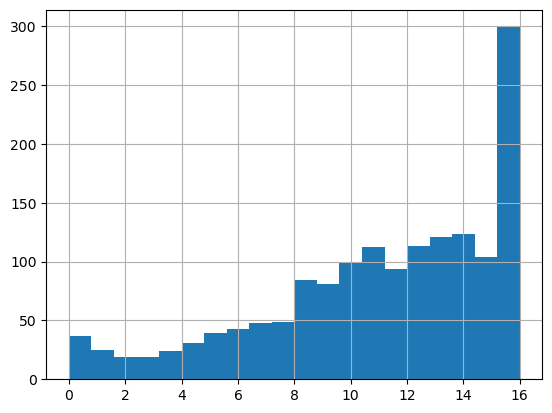

In [75]:
nonresident['fa21_gpa'].apply(lambda x: x ** 2).hist(bins=20)

In [71]:
from scipy.stats import boxcox

# Apply Box-Cox transformation
transformed_data, lambda_value = boxcox(nonresident['fa21_cred'])
df['Transformed'] = transformed_data

ValueError: Data must be positive.

In [ ]:
nonresident.to_excel('transformed.xlsx', index=False)

In [68]:
nonresident.drop(columns=[
                          'Currently Enrolled'
                         ], inplace=True)

(array([4.34998118e-01, 1.23911647e-01, 4.19628737e-02, 1.63259813e-02,
        8.41808408e-03, 4.40036213e-03, 2.42338784e-03, 1.78565420e-03,
        1.02037383e-03, 7.65280371e-04, 4.46413550e-04, 1.91320093e-04,
        1.91320093e-04, 2.55093457e-04, 0.00000000e+00, 1.27546729e-04,
        1.91320093e-04, 6.37733643e-05, 6.37733643e-05, 6.37733643e-05,
        0.00000000e+00, 0.00000000e+00, 6.37733643e-05, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 6.37733643e-05]),
 array([2.69279397e-02, 1.59498070e+00, 3.16303346e+00, 4.73108623e+00,
        6.29913899e+00, 7.86719175e+00, 9.43524451e+00, 1.10032973e+01,
        1.25713500e+01, 1.41394028e+01, 1.57074556e+01, 1.72755083e+01,
        1.88435611e+01, 2.04116138e+01, 2.19796666e+01, 2.35477194e+01,
        2.51157721e+01, 2.66838249e+01, 2.82518777e+01, 2.98199304e+01,
        3.13879832e+01, 3.29560359e+01, 3.45240887e+01, 3.60921415e+01,
        3.76601942e+01

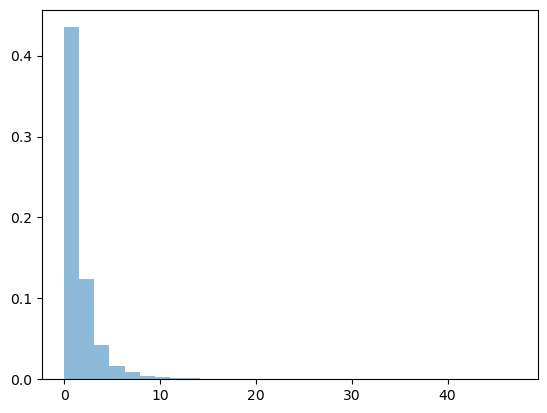

In [66]:
import matplotlib.pyplot as plt

data = np.random.normal(0, 1, 10000)
s_data = math.e ** data

plt.hist(s_data, bins=30, density=True, alpha=0.5)